# PLATON: PLanetary Atmospheric Transmission for Observer Noobs 

**PLATON** is an exoplanetary atmospheric retreival code that fits a sample transmission spectra to observational data from space telescopes. This examples will process the well constrained exoplanet HD2095458b.

An **exoplanet** is a planet that orbits a star other than our own.

A **transit** is the fortuitous event when the planet passes in front of its host star. The depth of a transit is related to the amount of starlight that is absorbed by the exoplanet's atmosphere.  
An **eclipse** is the fortuitous event when the planet passes behind its host star. The depth of an eclipse is related to the amount of planetary thermal energy (IR emission) that is absorbed by the exoplanet's atmosphere above the photosphere (source of IR emission).  

A **transmission spectrum** is a connected sequence of transit depths (area ratio of the planet-to-star size during transit: (Rp/Rs)^2 ) over a range of wavelengths. That is to say that the transit depth (i.e. relative absorption by (planet + atmosphere) / (size of star) ) changes with wavelength because the atmospheric particles (e.g. gas, clouds, haze) have wavelength dependent absoprtion properties -- the atmosphere absorbs more photons at the core of molecular features compared to the wings thereof.

An **emission spectrum** is a connected sequence of eclipse depths (flux ratio of the planet-to-star emission during transit: Fp/Fs ) over a range of wavelengths. That is to say that the eclipse depth (i.e. relative emission by (planet + atmosphere) / (emission by star) ) changes with wavelength because the atmospheric particles (e.g. gas, clouds, haze) have wavelength dependent absoprtion properties -- the atmosphere absorbs more photons at the core of molecular features compared to the wings thereof.

A **Retrieval** is the numerical process (usually *Bayesian*) to invert the transmission or emission spectrum (here transmission) into a measurement of the abundances of particles (gas, clouds, hazes) 

# Model Parameters

### Planet/Star Parameters
* `Rp` - radius of the planet in units of Jupiter Radii
* `Rstar` - radius of the planet in units of Solar Radii
* `Mp` - mass of the planet in units of Jupiter Mass 

### Temperature-Pressure Profile Parameters

The thermal profile used in the model assumes the atmosphere to be in radiative equilibrium based upon the analytic radiative equilibrium temperature profile of Guillot 2010. This profile assumes one downwelling visible channels of radiation and one upwelling stream of thermal emission.

* `Tirr` - temperature at the top of atmosphere in Kelvin
* `logKir` - log of the Planck mean thermal infrared opacity
* `logg1` - log of the ratio of the Planck mean opacities in the visible stream to the thermal stream

### Chemistry Parameters
* `logMet` - log Metallicity
* `logCtoO` - log of the ratio Carbon to Oxygen abundance
* `logPQC` - log of the pressure of Carbon quenching
* `logPQN` - log of the pressure of Nitrogen quenching

### Cloud Parameters
* `logRayAmp` - log of the amplitude of Rayleigh scattering
* `RaySlp` - Slope of Rayleigh scattering
* `logPc` - Pressure level of cloud deck in mbar


---

We are adding the reload functionality to this Jupyter notebook in case the user wishes to make on the fly changes to the included software packages

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We are adding the reload functionality to this Jupyter notebook in case the user wishes to make on the fly changes to the included software packages

In [90]:
%matplotlib inline

We are loading the neccesary built in python libraries here

In [91]:
from __future__ import print_function

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

from multiprocessing import Pool, cpu_count

import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

from datetime import datetime
from pandas import DataFrame
from sklearn.externals import joblib

Let's set the figure dimensions to nominal values

In [92]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (5,5)

If you already have `emcee` installed, then this will load it.  
If you do not already have `emcee` installed, then this install it first, then load it.  

In [ ]:
try:
    import emcee
except:
    !pip install git+https://github.com/dfm/emcee
    import emcee

If you already have `nestle` installed, then this will load it.  
If you do not already have `nestle` installed, then this install it first, then load it.  

In [93]:
try:
    import nestle
except:
    !pip install nestle
    import nestle

If you already have `platon` installed, then this will load it.  
If you do not already have `platon` installed, then this install it first, then load it.  

We are using my github fork because it includes modifications for plotting and usage of the progress bar

In [95]:
try:
    import platon
    del platon
except:
    !pip install git+https://github.com/exowanderer/platon

If you already have `pygtc` installed, then this will load it.  
If you do not already have `pygtc` installed, then this install it first, then load it.  

We are using my github fork because it includes modifications for plotting with mulitnest.

In [ ]:
try:
    from pygtc import plotGTC
except:
    !pip install git+https://github.com/exowanderer/pygtc
    from pygtc import plotGTC

Here we are loading the necessary `platon` library functions, such as `platon.fit_info`, `platon.transit_depth_calculator`, etc

In [96]:
from platon.fit_info import FitInfo
from platon.retriever import Retriever
from platon.constants import R_sun, R_jup, M_jup
from platon.constants import METRES_TO_UM
from platon.transit_depth_calculator import TransitDepthCalculator
from platon.errors import AtmosphereError

# Plotting and Helper Functions

Now we will define useful computation and plotting functions. These are not necessary for `platon` to operate; but they streamline the plotting procedures for later.

Starting with a model that computes the high resolution atmospheric model from the best-fit (or other) parameters derived below.

In [ ]:
def compute_new_model(result, fit_info, bayesian_model='emcee', wave_min=0.2e-6, wave_max=9.0e-6, n_theory_pts=500, include_condensation=True):

    wavelengths_theory = np.linspace(wave_min, wave_max, n_theory_pts)
    half_diff_lam = 0.5*np.median(np.diff(wavelengths_theory))

    # Setup calculator to use the theoretical wavelengths
    calculator = TransitDepthCalculator(include_condensation=include_condensation)
    calculator.change_wavelength_bins(np.transpose([wavelengths_theory-half_diff_lam, wavelengths_theory+half_diff_lam]))

    retriever._validate_params(fit_info, calculator)

    # Allocate the best-fit parameters from the `result` class
    if bayesian_model == 'multinest':
        best_params_arr = result.samples[np.argmax(result.logl)]
    elif bayesian_model == 'emcee':
        best_params_arr = result.flatchain[np.argmax(result.flatlnprobability)]
    else:
        raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")

    best_params_dict = {key:val for key,val in zip(fit_info.fit_param_names, best_params_arr)}

    # Set the static parameteres to the default values
    for key in fit_info.all_params.keys():
        if key not in best_params_dict.keys():
            best_params_dict[key] = fit_info.all_params[key].best_guess

    # Assign the best fit model parameters to necessary variables
    Rs = best_params_dict['Rs']
    Mp = best_params_dict['Mp']
    Rp = best_params_dict['Rp']
    T_eq = best_params_dict['T']
    logZ = best_params_dict['logZ']
    CO_ratio = best_params_dict['CO_ratio']
    log_cloudtop_P = best_params_dict['log_cloudtop_P']
    log_scatt_factor = best_params_dict['log_scatt_factor']
    scatt_slope = best_params_dict['scatt_slope']
    error_multiple = best_params_dict['error_multiple']
    T_star = best_params_dict['T_star']

    T_spot = best_params_dict['T_spot']
    spot_cov_frac = best_params_dict['spot_cov_frac']
    frac_scale_height = best_params_dict['frac_scale_height']
    log_number_density = best_params_dict['log_number_density']
    log_part_size = best_params_dict['log_part_size']
    part_size_std = best_params_dict['part_size_std']
    ri = best_params_dict['ri']

    # Compute best-fit theoretical model
    try:
        wavelengths, calculated_depths = calculator.compute_depths(
            Rs, Mp, Rp, T_eq, logZ, CO_ratio,
            scattering_factor=10**log_scatt_factor, scattering_slope=scatt_slope,
            cloudtop_pressure=10**log_cloudtop_P, T_star=T_star)
        
        return wavelengths, calculated_depths
    except AtmosphereError as error_message:
        return str(error_message)

This next funciton computes the high resolution atmospheric model (see above) and plots the model with the given data.

In [ ]:
def plot_high_res_model_and_data(wave_data, t_depths, td_errors, result, fit_info, bayesian_model='emcee', wave_min=0.2e-6, wave_max=9.0e-6, n_theory_pts=500, include_condensation=True):
    # Plot the data on top of the best fit high-resolution model
    
    wave_min = wave_data.min()
    wave_max = wave_data.max()
    
    computed_model = compute_new_model(result=result, fit_info=fit_info, bayesian_model=bayesian_model, 
                                                       wave_min=wave_min, wave_max=wave_max, n_theory_pts=n_theory_pts, 
                                                       include_condensation=include_condensation)

    if isinstance(computed_model,str):
        raise AtmosphereError(computed_model)
    else:
        wavelengths, calculated_depths = computed_model
    
    plt.figure(figsize=(10,5))
    plt.errorbar(METRES_TO_UM * wave_data, t_depths, yerr=td_errors, fmt='.', color='k', zorder=100)
    plt.plot(METRES_TO_UM * wavelengths, calculated_depths)

    plt.xlabel("Wavelength (um)")
    plt.ylabel("Transit depth")
    plt.xscale('log')

    plt.tight_layout()

    if bayesian_model == 'multinest':
        plt.savefig('multinest_best_fit_{}.png'.format(time_stamp))
    elif bayesian_model == 'emcee':
        plt.savefig('emcee_best_fit_{}walkers_{}steps_{}.png'.format(nwalkers, nsteps, time_stamp))
    else:
        raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")

The next function takes as input the output of either `emcee` or `nestle` and plots the marginalized distribution and correlation plots for the Bayesian analysis below.

In [ ]:
def plot_gtc_platon(result, fit_info, time_stamp='NotGiven', 
                    bayesian_model='emcee', fit_param_names=None, 
                    nContourLevels=3, label_fontsize=10, 
                    tick_fontsize=7, figureSize=12):
    
    # GTC: Grand Triangle of Confusion; i.e. Prettier Corner Plot
    if bayesian_model == 'multinest':
        res_flatchain_df = DataFrame(result.samples.copy(), columns=fit_info.fit_param_names)
    elif bayesian_model == 'emcee':
        res_flatchain_df = DataFrame(result.flatchain.copy(), columns=fit_info.fit_param_names)
    else:
        raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")
    
    if fit_param_names is None: fit_param_names = fit_info.fit_param_names
    
    if 'Rs' in fit_info.fit_param_names: res_flatchain_df['Rs'] = res_flatchain_df['Rs'] / R_sun
    if 'Rp' in fit_info.fit_param_names: res_flatchain_df['Rp'] = res_flatchain_df['Rp'] / R_jup
    if 'Mp' in fit_info.fit_param_names: res_flatchain_df['Mp'] = res_flatchain_df['Mp'] / M_jup
    
    pygtc_out = plotGTC(res_flatchain_df.values,
                        weights=result.weights if bayesian_model == 'multimodel' else None,
                        nContourLevels=nContourLevels, 
                        paramNames=fit_param_names,
                        customLabelFont={'size':label_fontsize},
                        customTickFont={'size':tick_fontsize},
                        figureSize=figureSize);

    if bayesian_model == 'multinest':
        plt.savefig('multinest_gtc_{}.png'.format(time_stamp))
    elif bayesian_model == 'emcee':
        plt.savefig('emcee_gtc_{}walkers_{}steps_{}.png'.format(nwalkers, nsteps, time_stamp))
    else:
        raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")

These helper functions simply store the measured transit depths of HD209458b at multiple wavelengths, by instrument.

In [155]:
def hd209458b_stis():
    #http://iopscience.iop.org/article/10.1086/510111/pdf
    star_radius = 1.125 * R_sun
    wave_bins = [[293,347], [348,402], [403,457], [458,512], [512,567], [532,629], [629,726], [727,824], [825,922], [922,1019]]
    wave_bins = 1e-9 * np.array(wave_bins)

    planet_radii = [1.3263, 1.3254, 1.32, 1.3179, 1.3177, 1.3246, 1.3176, 1.3158, 1.32, 1.3268]
    radii_errors = [0.0018, 0.0010, 0.0006, 0.0006, 0.0010, 0.0006, 0.0005, 0.0006, 0.0006, 0.0013]
    transit_depths = (np.array(planet_radii)*R_jup/star_radius)**2 + 60e-6
    transit_errors = np.array(radii_errors)/np.array(planet_radii) * 2 * transit_depths
    return wave_bins, transit_depths, transit_errors

def hd209458b_wfc3():
    #https://arxiv.org/pdf/1302.1141.pdf
    wavelengths = 1e-6*np.array([1.119, 1.138, 1.157, 1.175, 1.194, 1.213, 1.232, 1.251, 1.270, 1.288, 1.307, 1.326, 1.345, 1.364, 1.383, 1.401, \
                                 1.420, 1.439, 1.458, 1.477, 1.496, 1.515, 1.533, 1.552, 1.571, 1.590, 1.609, 1.628])
    wavelength_bins = [[w-0.0095e-6, w+0.0095e-6] for w in wavelengths]
    depths = 1e-6 * np.array([14512.7, 14546.5, 14566.3, 14523.1, 14528.7, 14549.9, 14571.8, 14538.6, 14522.2, 14538.4, 14535.9, 14604.5, 14685.0, \
                              14779.0, 14752.1, 14788.8, 14705.2, 14701.7, 14677.7, 14695.1, 14722.3, 14641.4, 14676.8, 14666.2, 14642.5, 14594.1, \
                              14530.1, 14642.1])
    errors = 1e-6 * np.array([50.6, 35.5, 35.2, 34.6, 34.1, 33.7, 33.5, 33.6, 33.8, 33.7, 33.4, 33.4, 33.5, 33.9, 34.4, 34.5, 34.7, 35.0, 35.4, 35.9, \
                              36.4, 36.6, 37.1, 37.8, 38.6, 39.2, 39.9, 40.8])
    return np.array(wavelength_bins), depths, errors

def hd209458b_spitzer():
    #https://arxiv.org/pdf/1504.05942.pdf

    wave_bins = []
    depths = []
    errors = []

    wave_bins.append([3.2, 4.0])
    RpRs = np.average([0.12077, 0.1222, 0.11354, 0.11919], weights=1.0/np.array([0.00085, 0.00062, 0.00087, 0.00032]))
    depths.append(RpRs**2)
    errors.append(0.00032/RpRs * 2 * depths[-1])

    wave_bins.append([4.0, 5.0])
    RpRs = np.average([0.12199, 0.12099], weights=1.0/np.array([0.00094, 0.00029]))
    depths.append(RpRs**2)
    errors.append(0.00029/RpRs * 2 * depths[-1])

    wave_bins.append([5.1, 6.3])
    RpRs = np.average([0.12007, 0.11880], weights=1.0/np.array([0.00248, 0.00272]))
    depths.append(RpRs**2)
    errors.append(0.00248/RpRs * 2 * depths[-1])

    wave_bins.append([6.6, 9.0])
    RpRs = np.average([0.12007, 0.11991], weights=1.0/np.array([0.00114, 0.00073]))
    depths.append(RpRs**2)
    errors.append(0.00073/RpRs * 2 * depths[-1])

    return 1e-6*np.array(wave_bins), np.array(depths), np.array(errors)

---
# Data processing and Retrieval Pipeline

Here we define the input data for the retrieval algorithm.

In [157]:
stis_bins, stis_depths, stis_errors = hd209458b_stis()
wfc3_bins, wfc3_depths, wfc3_errors = hd209458b_wfc3()
spitzer_bins, spitzer_depths, spitzer_errors = hd209458b_spitzer()

Here we combine the input data for the retrieval algorithm into one array each.

In [99]:
wave_bins = np.concatenate([stis_bins, wfc3_bins, spitzer_bins])
depths = np.concatenate([stis_depths, wfc3_depths, spitzer_depths])
errors = np.concatenate([stis_errors, wfc3_errors, spitzer_errors])

This is the base class for the `platon` retrieval algorithm. It contains all of the necessary functionality below.

In [101]:
#create a Retriever object
retriever = Retriever()

Here is our initial guess for each of the fitted and non-fitted parameters that `platon` depends on.

In [102]:
R_guess = 1.4 * R_jup
T_guess = 1200

Rs = 1.19 * R_sun
Mp = 0.73 * M_jup
Rp = R_guess
T_eq = T_guess
logZ = 0
CO_ratio = 0.53
log_cloudtop_P = 4
log_scatt_factor = 0
scatt_slope = 4
error_multiple = 1
T_star = 6091

Now we will wrapp all of the above parameters into the `platon` specific `fit_info` instance.  
This is a method to contain all and only the necessary information to pass to `platon`.

In [103]:
#create a FitInfo object and set best guess parameters
fit_info = retriever.get_default_fit_info(
                        Rs=Rs, Mp=Mp, Rp=Rp, T=T_eq,
                        logZ=logZ, CO_ratio=CO_ratio, 
                        log_cloudtop_P=log_cloudtop_P,
                        log_scatt_factor=log_scatt_factor, 
                        scatt_slope=scatt_slope, 
                        error_multiple=error_multiple, 
                        T_star=T_star)

Here we are adding our Bayesian priors onto the `platon` model format.  
Only the parameters listed here will be varrid during the subsequence `emcee` or `nestle` Bayesian estimation routines.

In [104]:
#Add fitting parameters - this specifies which parameters you want to fit
#e.g. since we have not included cloudtop_P, it will be fixed at the value specified in the constructor
fit_info.add_gaussian_fit_param('Rs', 0.02*R_sun)
fit_info.add_gaussian_fit_param('Mp', 0.04*M_jup)

fit_info.add_uniform_fit_param('Rp', 0.9*R_guess, 1.1*R_guess)
fit_info.add_uniform_fit_param('T', 0.5*T_guess, 1.5*T_guess)
fit_info.add_uniform_fit_param("log_scatt_factor", 0, 1)
fit_info.add_uniform_fit_param("logZ", -1, 3)
fit_info.add_uniform_fit_param("log_cloudtop_P", -0.99, 5)
fit_info.add_uniform_fit_param("error_multiple", 0.5, 5)

This is a time stamp label to associate all outputs from the same run through in the storage device (i.e. hard drive).  
All outputs from this operation will have the same time stamp. We should avoid over writing new results with the same time stamp.

In [162]:
time_stamp = datetime.utcnow().strftime("%Y%m%d%H%M%S")

These values for the `emcee` are a nominal starting position that will allow us to confirm that the code without programming fails. The results should not be taken as accurate or converged. To perform a robust analysis, we would need ~$10^6$ operations: i.e. nwalkers = 1000; nsteps = 1000. A full, converged chain may take 24+ hours to compute.

Moroever, `emcee` is likely not the best approach to fully understand the atmospheric parameter space.  
It is highly recommended to use `bayesian_model = 'multinest'`, which could take *3+ days* to converge; but is far more likely to accurately measure the parameter space.

This setup will take ~1 minute to run; but the results are not converged, to say the least.

In [158]:
bayesian_model = 'emcee' # 'multinest'
nwalkers = 50
nsteps = 10

Here is the powerhouse of the `platon` algorithm that operates either the `emcee` or `multinest` Bayesian models. 

We will use the emcee model because it is easier to control how long a completed (not converged) operation will take. Multinest (via `nestle`) is far more likely to accurate probe the full parameter space volume; but it could take ~3 days to converge. Emcee will most likely focus on one mode of many; but we can control how long our computers operate by setting the `nwalkers` and `nsteps` parameters above. 

The nominal use case has shown that each walker and step should take 0.1 seconds.

That is to say that 50 walkers and 20 steps should take 0.1 x 50 x 20 = 100 seconds; and 1000 walkers and 1000 steps should take 0.1 x 1000 x 1000 = 100k seconds = ~28 hours

In [159]:
if bayesian_model == 'multinest':
    #Use Nested Sampling to do the fitting
    # with ThreadPoolExecutor() as executor:
    # with ProcessPoolExecutor() as executor:
    with Pool(cpu_count()) as executor:
        result = retriever.run_multinest(wave_bins, depths, errors, fit_info, nestle_kwargs={'pool':executor})#, 'bootstrap':0 # bootstrap for `dynesty`
    
    result_dict = {'samples':result.samples, 'weights':result.weights, 'logl':result.logl}
    joblib.dump(result_dict, 'multinest_results_{}.joblib.save'.format(time_stamp))
elif bayesian_model == 'emcee':
    #Use Affine Invariant Ensemble MCMC  to do the fitting
    result = retriever.run_emcee(wave_bins, depths, errors, fit_info, nwalkers=nwalkers, nsteps=nsteps)
    
    result_dict = {'flatchain':result.flatchain, 'flatlnprob':result.flatlnprobability, 'chain':result.chain, 'lnprob':result.lnprobability}
    joblib.dump(result_dict, 'emcee_results_{}walkers_{}steps_{}.joblib.save'.format(nwalkers, nsteps, time_stamp))
else:
    raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")

100%|██████████| 100/100 [16:55<00:00, 10.33s/it]

100/100 -977.3724529663649 [8.34373184e+08 1.43821256e+27 1.00319764e+08 1.16064294e+03
 8.00152986e-01 2.97854451e+00 4.52519230e+00 4.13944682e+00]
#Parameter Lower_error Median Upper_error Best_fit
Max_lnprob 256.98416795570404
Rs 11427527.918512464 828428891.1432129 10421658.432670116 827983794.2146076
Mp 6.066370973139464e+25 1.3861860458211643e+27 6.906230132876915e+25 1.4122626689580364e+27
Rp 1624022.1930415928 97882831.81905529 1649899.4910416007 98128152.38613349
T 151.28150298149308 1119.50130750623 235.47543554485424 1005.7088234446086
log_scatt_factor 0.18716463885921397 0.5000733366731508 0.24057692033601874 0.5619587563450509
logZ 0.7798793654864427 0.7838526177638403 1.3208255838352005 0.029061924356393737
log_cloudtop_P 0.9731165866196796 2.384987338016433 0.7907561829664096 3.0685658691896855
error_multiple 0.6204624377393162 3.1209405471151537 0.6789436810671852 2.4074181713898604



---
Next we will plot the best fit model to confirm that our fitting algorithm did not run off a cliff into an unphysical parameter space.  
As long as the blue model is close to the black dots, then we should be happy.  

To attain better convergence, we could modify the atmospheric model *or* iterate the Bayesian longer -- possibly with different priors or intial conditions.

0.293 - 9.0 microns


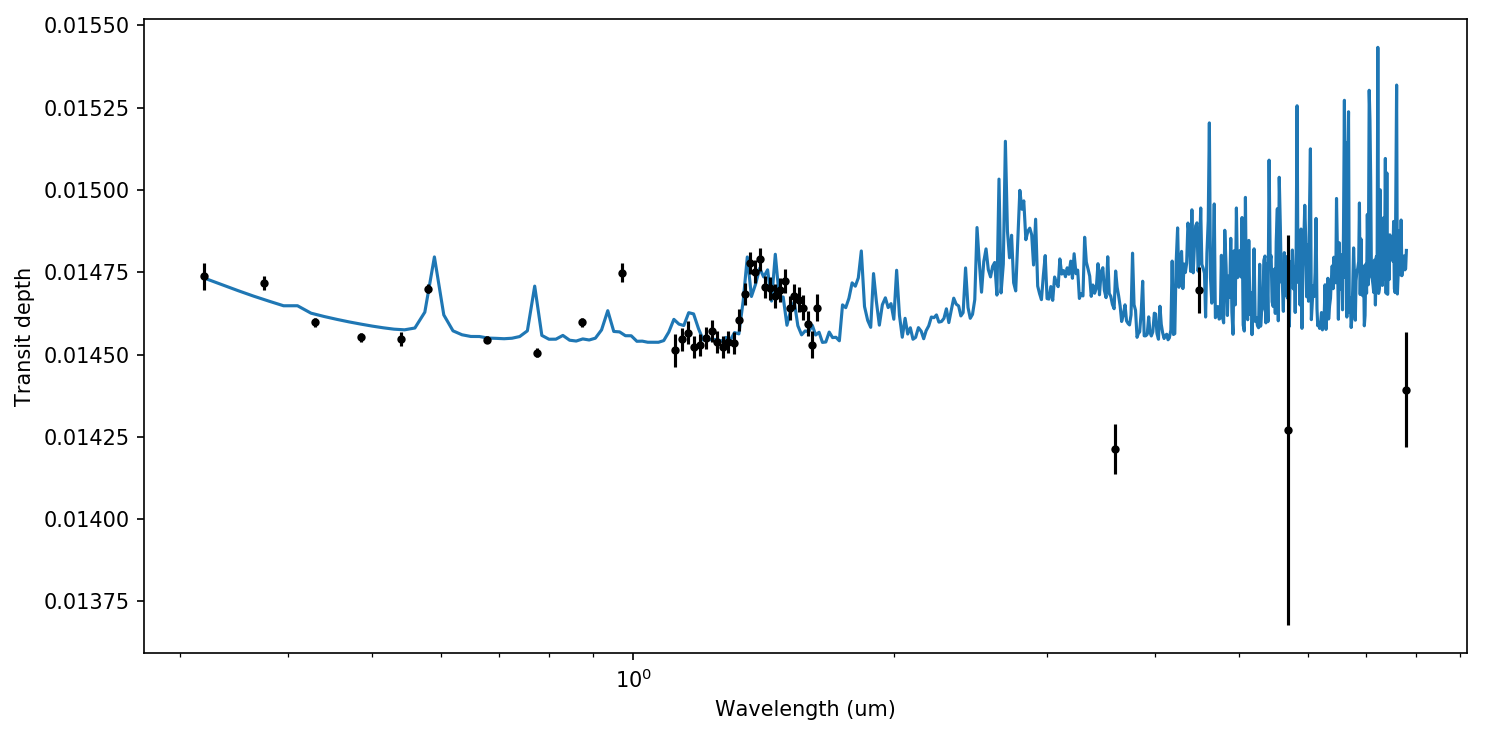

In [160]:
# Establish the Range in Wavelength to plot high resolution figures
wave_min = wave_bins.min()
wave_max = wave_bins.max()
print('{:.3f} - {:.1f} {}'.format(wave_min*1e6,wave_max*1e6, 'microns'))

wave_data = np.mean(wave_bins, axis=1)

plot_high_res_model_and_data(wave_data=wave_data, t_depths=depths, td_errors=errors, result=result, fit_info=fit_info)

Finally we will examine the distribution and correlations for each of our 8 parameters. The diagrams can be interpretted as:

(1) The 1D histograms represent the 3-sigma width of the marginalized Bayesian Credible Regions: Bayesian version of *confidence interval*.

(2) The 2D histograms represent the $N(N-1)/2$ combinations of correlations between each of our N parameters (N=8 here).  
If the 2D histograms are reasonably circular, then we can assume that the correlations are Gaussian, that is to say that they reflect the intrinsic uncertainty of the measurements; as oppose to correlations between any 2 of the parameters.  
If the 2D histograms show obvious structure (linear trensds, multimodel populations, etc), then we should assume that parameter correlations may have an effect on the reported values and uncertainties. 

If we a linear trend between two physically correlated values (i.e. Rp and Mp), then the explanation is trivial.  
If find a linear trend between two parameters without any known correlations, then we should investigate more closely.  
If we find a non-linear trend between any two parameters, it should be investigated more closely.  
If we see a bimodel or multimodel distribution, then we should investigate further -- nominally, the solution may require more data, which would probably require more observations.

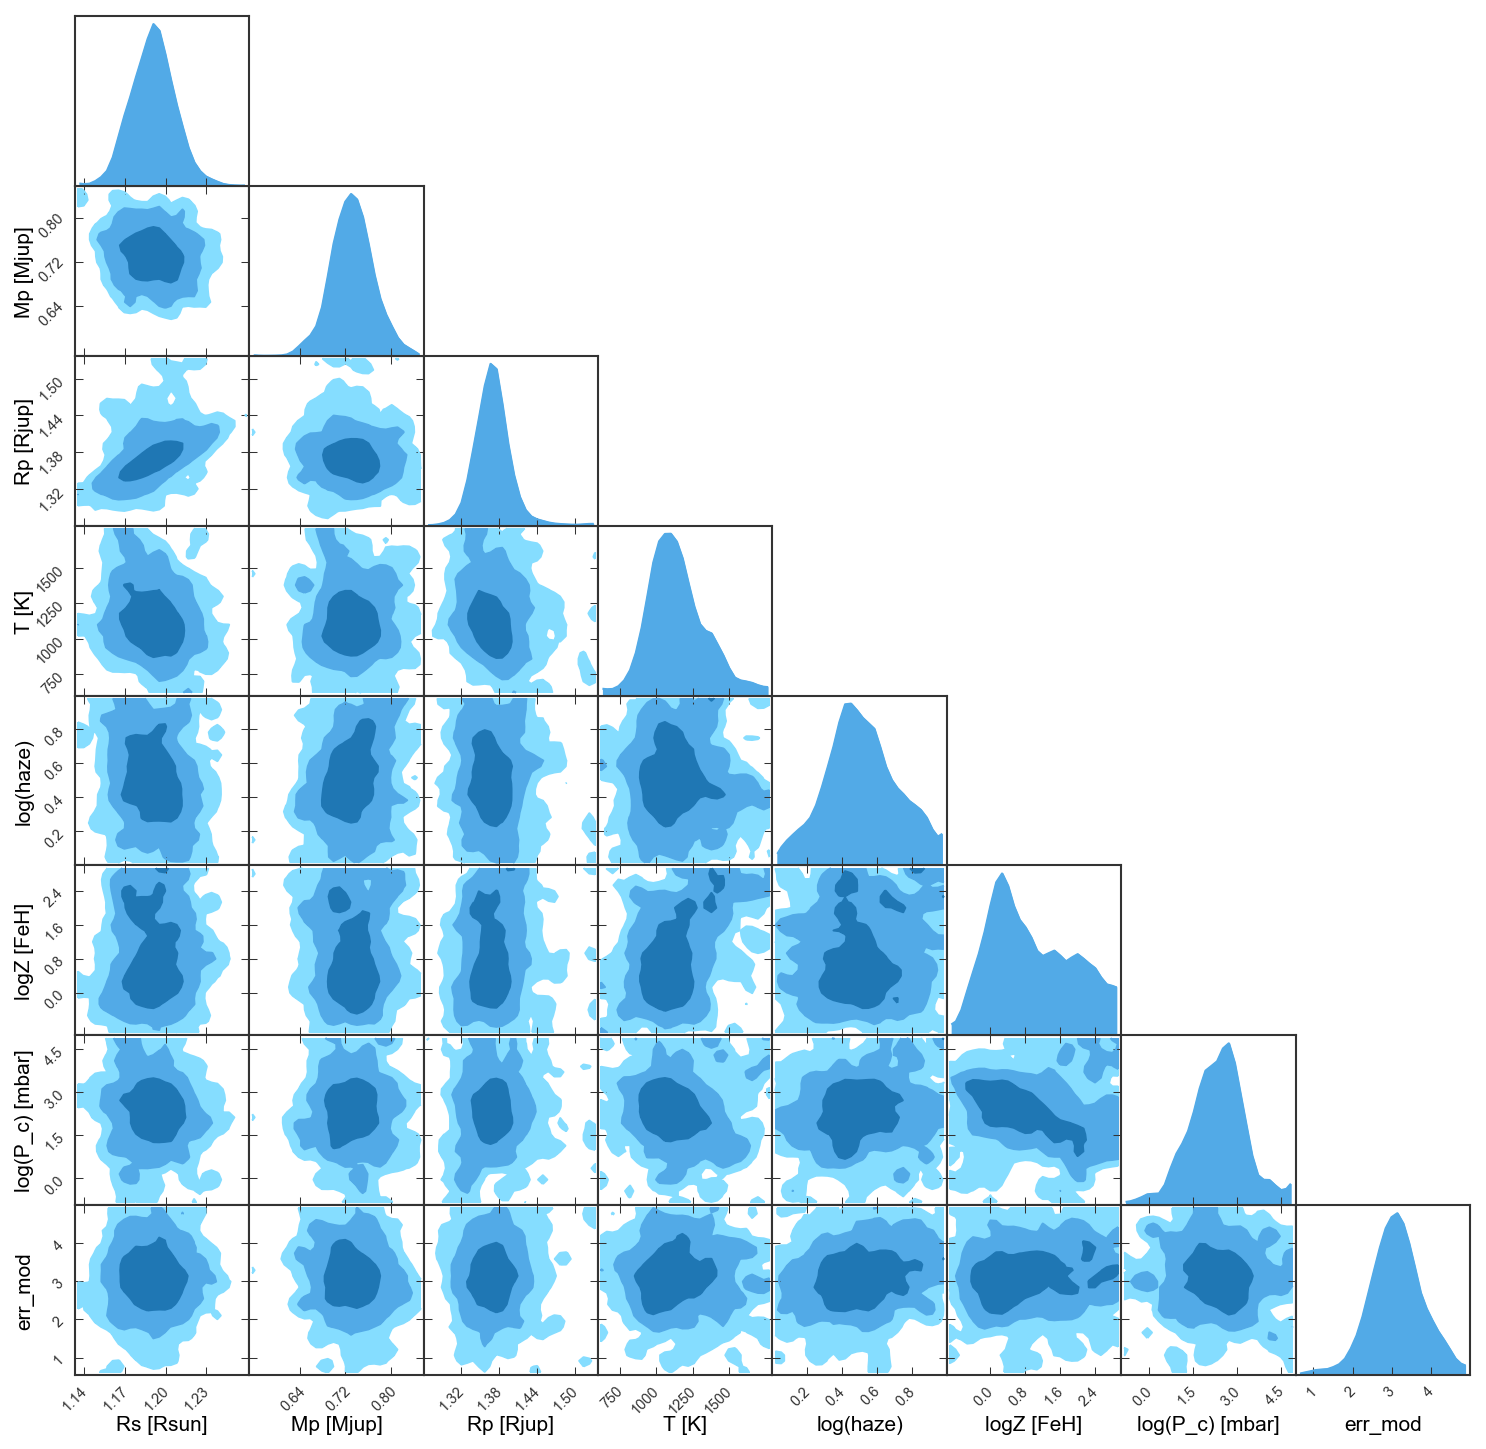

In [161]:
fit_param_names = ['Rs [Rsun]', 'Mp [Mjup]', 'Rp [Rjup]', 'T [K]', 'log(haze)', 'logZ [FeH]', 'log(P_c) [mbar]', 'err_mod']
plot_gtc_platon(result, fit_info, bayesian_model='emcee', fit_param_names=fit_param_names, nContourLevels=3)